# qBraid-SDK: Devices and Jobs

Enable qBraid Quantum Jobs through the qBraid CLI, available only through https://lab.qbraid.com

In [1]:
!qbraid

Welcome to the qBraid CLI!
---------------------------
Use `qbraid -h` to see available commands.

        ____            _     _  
   __ _| __ ) _ __ __ _(_) __| | 
  / _  |  _ \|  __/ _  | |/ _  | 
 | (_| | |_) | | | (_| | | (_| | 
  \__  |____/|_|  \__ _|_|\__ _| 
     |_|                         


Use `qbraid --version` to display the current version.

Reference Docs: https://qbraid-qbraid.readthedocs-hosted.com/en/stable/cli/qbraid.html


In [2]:
!qbraid --version

qbraid-cli/0.1.2 aws-cli/1.25.17 azure-cli/2.37.0 pip/22.1.2 Python/3.9.10


In [3]:
!qbraid jobs enable qbraid_sdk

Successfully enabled qBraid Quantum Jobs in the qbraid_sdk environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys/tokens are necessary. 

To disable, run: `qbraid jobs disable -n qbraid_sdk`


In [4]:
import qbraid

qbraid.__version__

'0.1.3'

## Unified quantum device search

There's no such function in Qiskit or Cirq, only tedious work-arounds that require you to look into the docs anyways. For Braket, it requires making an authenticated API request through Boto3, and only includes credentialed devices in the response.

The qBraid-SDK lists all available QPU's and simulators available through Qiskit, Cirq, and Braket, all in one place.

In [5]:
from qbraid import get_devices

In [6]:
get_devices()

Provider,Name,qBraid ID,Status
AWS,Braket Default Simulator,aws_braket_default_sim,●
AWS,Density Matrix Simulator,aws_dm_sim,●
AWS,State Vector Simulator,aws_sv_sim,●
AWS,Tensor Network Simulator,aws_tn_sim,●
D-Wave,Advantage_system4,aws_dwave_advantage_system4,●
D-Wave,DW_2000Q_6,aws_dwave_2000Q_6,●
Google,Bristlecone,google_bristlecone,○
Google,Cirq Density Matrix Simulator,google_cirq_dm_sim,●
Google,Cirq Sparse Simulator,google_cirq_sparse_sim,●
Google,Foxtail,google_foxtail,○


Filter your device search with many different advanced query options! 

For example, let's find simulators containing keyword "State" available through AWS or IBM:

In [7]:
get_devices(
    filters={
        "type": "Simulator",
        "name": {"$regex": "State"},
        "vendor": {"$in": ["AWS", "IBM"]},
    }
)

This time, let's search for all gate-based QPUs with at least 5 qubits that are online

In [8]:
get_devices(
    filters={
        "paradigm": "gate-based",
        "type": "QPU",
        "numberQubits": {"$gte": 5},
        "status": "ONLINE",
    }
)

Recently added the ability to search by preferred software package, for instance

In [9]:
get_devices(filters={"runPackage": "qiskit", "requiresCred": "false"})

## Run circuits on any device

In [10]:
from qbraid import device_wrapper, job_wrapper, get_jobs
from qbraid.api import ibmq_least_busy_qpu, verify_config

Copy the desired Device ID into the device wrapper function and you're on your way.

In [11]:
qbraid_device = device_wrapper("ibm_aer_qasm_sim")
qbraid_device.info

{'numberQubits': None,
 'visibility': 'public',
 'connectivityGraph': [],
 'qbraid_id': 'ibm_aer_qasm_sim',
 'name': 'Aer QASM Simulator',
 'provider': 'IBM',
 'paradigm': 'gate-based',
 'type': 'Simulator',
 'vendor': 'IBM',
 'runPackage': 'qiskit',
 'status': 'ONLINE',
 'calibrationData': [],
 'publishedStudies': [],
 'createdAt': '2022-03-10T04:08:18.968Z',
 'updatedAt': '2022-07-11T19:38:50.712Z',
 '__v': 0}

In [12]:
verify_config("IBM")

0

In [13]:
least_busy = ibmq_least_busy_qpu()  # requires credential
least_busy

'ibm_q_manila'

In [14]:
ibmq_id = "ibm_q_qasm_sim"
qbraid_ibmq_device = device_wrapper(ibmq_id)
qbraid_ibmq_device.vendor_dlo

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>

In [15]:
from qiskit import QuantumCircuit
import numpy as np

qiskit_circuit = QuantumCircuit(1, 1)

qiskit_circuit.h(0)
qiskit_circuit.ry(np.pi / 4, 0)
qiskit_circuit.rz(np.pi / 2, 0)
qiskit_circuit.measure(0, 0)

qiskit_circuit.draw()

┌───┐┌─────────┐┌─────────┐┌─┐
  q: ┤ H ├┤ Ry(π/4) ├┤ Rz(π/2) ├┤M├
     └───┘└─────────┘└─────────┘└╥┘
c: 1/════════════════════════════╩═
                                 0

Initialize quantum jobs and collect results, with the ability to extract wrapped objects at any step

In [16]:
shots = 2**10

qbraid_ibmq_job = qbraid_ibmq_device.run(qiskit_circuit, shots=shots)
qbraid_ibmq_job.status()

<JobStatus.VALIDATING: 2>

Submit quantum jobs to any supported device through the same simple and consistent protocol

In [17]:
google_id = "google_cirq_dm_sim"
qbraid_google_device = device_wrapper(google_id)

aws_id = "aws_dm_sim"
qbraid_aws_device = device_wrapper(aws_id)  # Credential handled by qBraid Quantum Jobs

In [18]:
qbraid_google_job = qbraid_google_device.run(qiskit_circuit, shots=shots)
qbraid_aws_job = qbraid_aws_device.run(qiskit_circuit, shots=shots)

## Monitor and manage your jobs from one location

In [19]:
get_jobs()

qBraid ID,Submitted,Status
aws_dm_sim-ryanjh88-qjob-mlnuz6fv0prgfkn2sv4d,2022-07-11T20:59:35.908Z,COMPLETED
ibm_q_qasm_sim-ryanjh88-qjob-cgui2yixesz0ghqeqyh5,2022-07-11T20:59:24.901Z,COMPLETED
aws_dm_sim-ryanjh88-qjob-ci3kybj94ntbqlyhvbwa,2022-07-11T20:47:51.520Z,COMPLETED
ibm_q_qasm_sim-ryanjh88-qjob-610x527eoqi7hz5z802y,2022-07-11T20:47:45.355Z,COMPLETED
ibm_q_qasm_sim-ryanjh88-qjob-ehrolezvuh5uersejqun,2022-07-11T20:46:58.766Z,COMPLETED
aws_dm_sim-ryanjh88-qjob-4aoe3cnlap8rukk33v6q,2022-07-11T20:08:00.756Z,COMPLETED
ibm_q_qasm_sim-ryanjh88-qjob-88rt582mve3v5hl60lkb,2022-07-11T20:07:52.859Z,COMPLETED
aws_dm_sim-ryanjh88-qjob-q3qzygxad2gs33ggebl3,2022-07-11T19:40:41.889Z,COMPLETED
ibm_q_manila-ryanjh88-qjob-jpvn8t5945yp6tsmaiaj,2022-07-11T19:40:34.010Z,COMPLETED
aws_dm_sim-ryanjh88-qjob-ag3obyyugsqeo2qi4nmm,2022-07-11T18:08:56.513Z,COMPLETED


In [20]:
qbraid_ibmq_job.wait_for_final_state()

In [21]:
jobs = [qbraid_google_job, qbraid_aws_job, qbraid_ibmq_job]
google_result, aws_result, ibmq_result = [job.result() for job in jobs]

## Easily compare results

In [22]:
print(f"{qbraid_google_device.name} counts: {google_result.measurement_counts()}")
print(f"{qbraid_aws_device.name} counts: {aws_result.measurement_counts()}")
print(f"{qbraid_ibmq_device.name} counts: {ibmq_result.measurement_counts()}")

Cirq Density Matrix Simulator counts: {'1': 866, '0': 158}
Density Matrix Simulator counts: {'1': 881, '0': 143}
IBMQ QASM Simulator counts: {'0': 144, '1': 880}


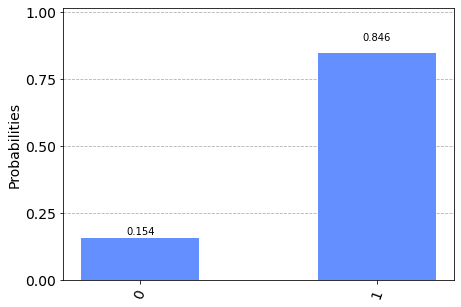

In [23]:
google_result.plot_counts()

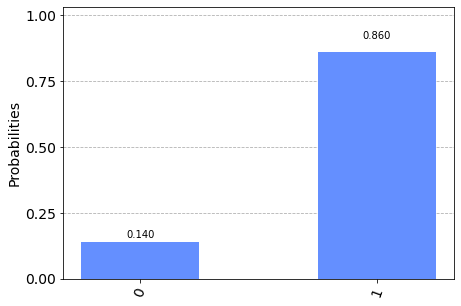

In [24]:
aws_result.plot_counts()

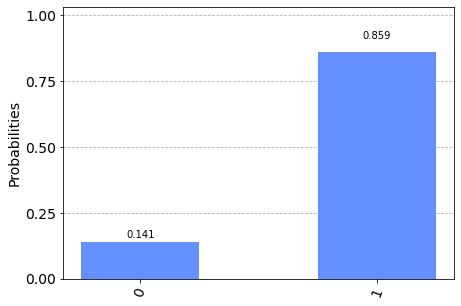

In [25]:
ibmq_result.plot_counts()